   r = Δx/ℓ    Δx  N (samples)  epsilon (theory)  \
0      0.50  0.50           41          0.000000   
1      0.75  0.75           27          0.000028   
2      1.00  1.00           21          0.001680   
3      1.25  1.25           17          0.011962   
4      1.60  1.60           13          0.049589   
5      2.00  2.00           11          0.116230   
6      2.50  2.50            9          0.208885   
7      3.00  3.00            7          0.295008   
8      4.00  4.00            6          0.432220   

   theory_floor_RMSE≈sqrt(epsilon·σ²)  observed_RMSE  recovered_%  
0                            0.000018       0.000330   100.000000  
1                            0.005296       0.010901    99.997196  
2                            0.040992       0.062032    99.831968  
3                            0.109369       0.170478    98.803837  
4                            0.222685       0.380309    95.041136  
5                            0.340925       0.663836    88.377003  
6  

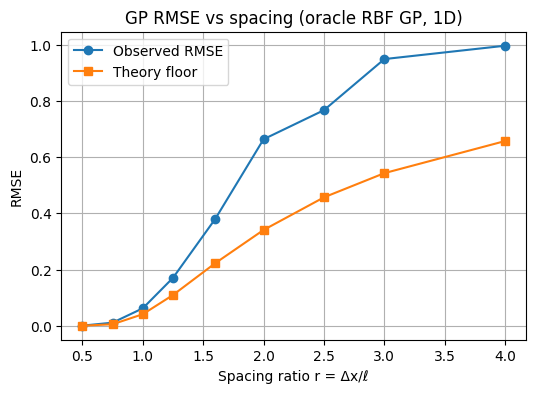

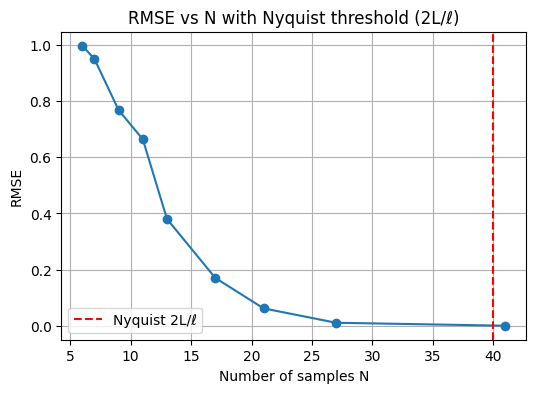

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from math import sqrt, pi
from mpmath import erfc

# -----------------------------
# Parameters
# -----------------------------
ell = 1.0         # true length-scale
sigma2 = 1.0      # variance
L = 20.0          # domain length
n_fine = 4000     # resolution for "truth"
noise = 1e-8      # numerical jitter
rng = default_rng(42)

# -----------------------------
# Helper functions
# -----------------------------
def make_rbf_gp_sample_1d(L, ell, nfft, rng):
    """Simulate a 1D GP with RBF kernel using spectral synthesis via FFT."""
    x_fft = np.linspace(0, L, nfft, endpoint=False)
    freqs = np.fft.fftfreq(nfft, d=L/nfft)
    omega = 2*np.pi*freqs
    # Spectral density of RBF kernel (up to constant)
    S = np.exp(-0.5 * (ell**2) * (omega**2))
    # Random Gaussian Fourier coefficients with Hermitian symmetry
    xi = (rng.normal(size=nfft) + 1j * rng.normal(size=nfft)) / np.sqrt(2.0)
    xi[0] = rng.normal()
    if nfft % 2 == 0:
        xi[nfft//2] = rng.normal()
    xi[1:nfft//2] = (rng.normal(size=nfft//2-1) + 1j*rng.normal(size=nfft//2-1))/np.sqrt(2.0)
    xi[nfft//2+1:] = np.conj(xi[1:nfft//2][::-1])
    Yw = np.sqrt(S) * xi
    y = np.fft.ifft(Yw).real
    y = y / np.std(y)  # normalize to unit variance
    return x_fft, y

def rbf_kernel(xa, xb, ell, sigma2):
    xa = xa.reshape(-1,1)
    xb = xb.reshape(1,-1)
    d2 = (xa - xb)**2
    return sigma2 * np.exp(-0.5 * d2 / (ell**2))

def gp_posterior_mean(x_train, y_train, x_test, ell, sigma2, noise):
    K = rbf_kernel(x_train, x_train, ell, sigma2) + noise * np.eye(len(x_train))
    Ks = rbf_kernel(x_train, x_test, ell, sigma2)
    Lc = np.linalg.cholesky(K)
    alpha = np.linalg.solve(Lc.T, np.linalg.solve(Lc, y_train))
    mu = Ks.T @ alpha
    return mu

# -----------------------------
# 1. Generate one GP realization (ground truth)
# -----------------------------
nfft = 4096
x_fft, y_fft = make_rbf_gp_sample_1d(L, ell, nfft, rng)
x_fine = np.linspace(0, L, n_fine, endpoint=False)
y_fine = np.interp(x_fine, x_fft, y_fft)

# -----------------------------
# 2. Subsample at different Δx/ℓ
# -----------------------------
r_values = np.array([0.5, 0.75, 1.0, 1.25, 1.6, 2.0, 2.5, 3.0, 4.0])
results = []

for r in r_values:
    dx = r * ell
    N = int(np.floor(L / dx)) + 1
    x_train = np.linspace(0, dx*(N-1), N, endpoint=True)
    y_train = np.interp(x_train, x_fine, y_fine)
    mu = gp_posterior_mean(x_train, y_train, x_fine, ell, sigma2, noise)
    rmse = np.sqrt(np.mean((mu - y_fine)**2))
    z = pi / (sqrt(2) * r)
    epsilon = float(erfc(z))
    results.append({
        "r = Δx/ℓ": r,
        "Δx": dx,
        "N (samples)": N,
        "epsilon (theory)": epsilon,
        "theory_floor_RMSE≈sqrt(epsilon·σ²)": np.sqrt(epsilon * sigma2),
        "observed_RMSE": rmse
    })

df = pd.DataFrame(results)
df["recovered_%"] = (1 - df["epsilon (theory)"]) * 100.0
print(df.round(6))

# -----------------------------
# 3. Plot RMSE vs spacing ratio
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(df["r = Δx/ℓ"], df["observed_RMSE"], marker='o', label="Observed RMSE")
plt.plot(df["r = Δx/ℓ"], df["theory_floor_RMSE≈sqrt(epsilon·σ²)"], marker='s', label="Theory floor")
plt.xlabel("Spacing ratio r = Δx/ℓ")
plt.ylabel("RMSE")
plt.title("GP RMSE vs spacing (oracle RBF GP, 1D)")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# 4. Plot RMSE vs number of samples, mark Nyquist
# -----------------------------
Nyq = 2*L/ell
plt.figure(figsize=(6,4))
plt.plot(df["N (samples)"], df["observed_RMSE"], marker='o')
plt.axvline(Nyq, linestyle='--', color='r', label="Nyquist 2L/ℓ")
plt.xlabel("Number of samples N")
plt.ylabel("RMSE")
plt.title("RMSE vs N with Nyquist threshold (2L/ℓ)")
plt.grid(True)
plt.legend()
plt.show()
